# Boosting

## Model Specification

The purpose of boosting is to sequentially apply the weak classification algorithm to repeatedly modified versions of the data,
thereby producing a sequence of weak classifiers. More specifically, the algorithm first trains a base classifier
(such as a Decision Tree) and uses it to make predictions on the training set. The algorithm then
increases the relative weight of misclassified training instances. Then it trains a second classifier,
using the updated weights, and again makes predictions on the training set, updates the instance
weights, and so on. The predictions from all of them are then combined through a weighted
majority vote to produce the final prediction. 

Formally, the schematic of the **AdaBoost** (or more precisly, AdaBoost.M1) procedure is as follows

1. Initialize the observation weights $w_i=1/N$, $i=1,2,\dots, N$.

2. For $m=1$ to $M$:
    
    a. Fit a classifier $G_m(x)\in\{-1, 1\}$ to the training data using weights $w_i$, i.e. the loss function is $\sum_{i=1}^Nw_i1(y_i\neq G_m(x_i))$.
    
    b. Compute 
    
    $$err_{m}=\frac{\sum_{i=1}^Nw_i1(y_i\neq G_m(x_i))}{\sum_{i=1}^Nw_i}$$.
    
    c. Compute $\alpha_m=\log((1-err_m)/err_m)$. (Sometimes it is $\alpha_m=\eta\log((1-err_m)/err_m)$, for an extra parameter of learning rate of $\eta$)
    
    d. Set $w_i\leftarrow w_i\cdot\exp[\alpha_m\cdot 1(y_i\neq G_m(x_i))],\;\;i=1,2,\dots, N.$
    
3. Output $G(x)=sign[\sum_{m=1}^M\alpha_m G_m(x)]$.

Intuitively, the subsequent classifiers $G_m$ will focus on those training observations that are missed by previous ones in the sequence. Thus as iterations proceed, observations that are difficult to classify correctly receive ever-increasing influence. This is related to the fact that boosting increase accuracy by correcting for bias. Simulation study in Figure 10.2 of ESL shows that AdaBoost can dramatically increase the performance of even a very weak classifier.

Though AdaBoost is previously motivated by a different perspective, but people then realize AdaBoost.M1 is **equivalent to forward stagewise additive modeling using the exponential loss function** $L(y, f(x))=\exp(-yf(x))$.

- Forward stagewise additive models approximates the final solution by sequencially adding new basis functions $b(x;\gamma_m)$ to the expansion $f(x) = \sum_{m=1}^M\beta_m b(x;\gamma_m)$ **without adjusting the parameters and coefficients of those that are already been added**. 

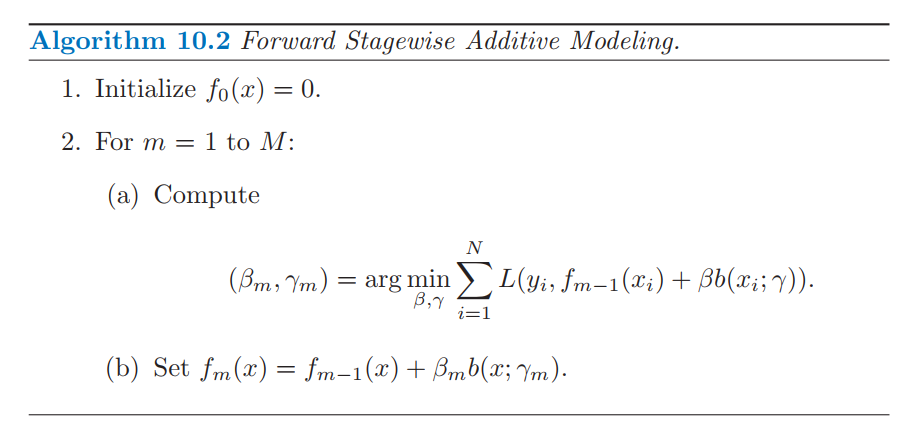

- The optimial function $f^{*}$ that minimizes the exponential loss function at population level is given by

$$f^*(x) = argmin_{f(x)}E_{Y|x}(e^{Yf(x)})=\frac{1}{2}\log\frac{Pr(Y=1|x)}{Pr(Y=-1|x)}.$$

That is, AdaBoost is essentially estimating one-half of the log-odds of $P(Y=1|x)$. This justifies using its sign at Step 3 above as the classification rule. Note that at population level, the exponential loss criterion leads to the same solution to the binomial negative log-likelihood or **deviance**:

$$-l(y, f(x)) := -l(y, p(x))=-1(Y=1)\log p(x) - 1(Y=-1)\log (1-p(x)) = \log(1+e^{-2Yf(x)}),$$

where there is a one-to-one correspondence between $p(x)$ and $f(x)$: $p(x) = \frac{1}{1+e^{-2f(x)}}$. Mark the resemblance between this and [logistic regression](logistic_regression.ipynb): there $f(x)$ is linear in $x$, while in here $f(x)$ can be nonlinear. 

### Variants and Generalizations

**Different Loss Functions than Exponential**

Exponential loss function is the signature of AdaBoost.M1 and leads to the simple reweighting in AdaBoost.M1, and computation speed is one of the main appeal of AdaBoost. But as discussed below, exponential loss also leads to the the non-robustness of AdaBoost, which makes it suceptible to e.g. misclassification of labels or situations where there is high Bayes error rate. 

A straightforward resolution is then to replace the loss functions. Alternative loss functions have to be approximating the misclassification loss function, since the latter is not continuous and not tractable in optimizations. More specifially, all of the below loss functions are actually **surrogate loss functions** - they are just there so that the optimization is easier to solve. Once the optimal solution is found, it is always a good practice to check the 0-1 loss metric to gauge the performance of the ML algo; see more discussions in [evaluation_metrics_and_information_criterions](../meta_learning/evaluation_metrics_and_information_criterions.ipynb). See below figure taken from ESL, and similar figure in [SVM](SVM.ipynb).

- **Quadratic functions** are easy to compute than exponentials. When margin is very negative, i.e. when $yf(x)<<-1$, the penalization is just quadratic and thus more robust than exponential. More importantly, it leads the elegant modular boosting algorithms in the context of forward stagewise additive modeling. It would be a good surrogate if it does not place increasing influence (error) on observations that are correctly classified with increasing certainty.

- The penalty associated with **binomial deviance** increase linearly for large increasingly negative margin whereas the exponential criterion increases influence on such criterion exponentially. Thus binomial deviance spreads the influences more evenly among all the data and more robust than the exponential loss.

- The **Huberized loss** achieves robustness and also the easy-to-compute benefit of quadratic loss. But this and other more robust alternatives do not give rise to simple and fast boosting algorithms. Thus to use a better loss function, it is the boosting algorithm that we need to change; see the description of gradient boosting below.

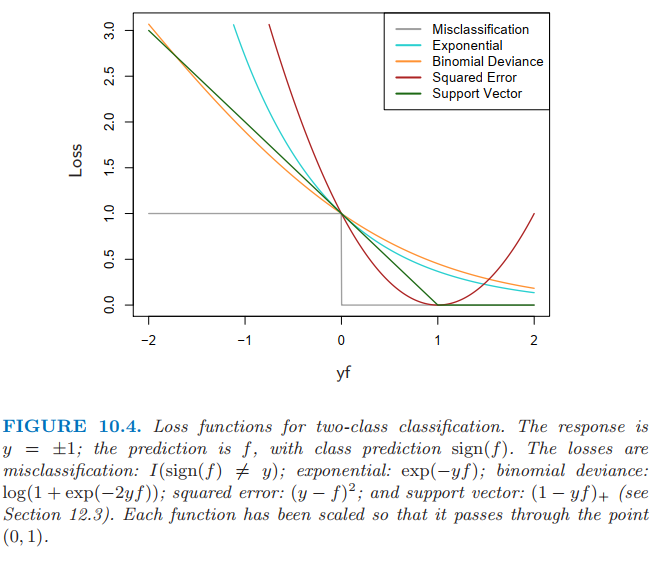

**Extension to $K$ classes**

- $K$-class multinomial deviance loss function:

$$L(y, p(x)) = -\sum_{k=1}^K1(y=\mathbb{G}_k)\log p_k(x) = -\sum_{k=1}^K1(y=\mathbb{G}_k)\log f_k(x) + \log(\sum_{l=1}^Ke^{f_l(x)}),$$

with symmetric constraint: $\sum_{k=1}^Kf_k(x)=0$.

- Exponential loss for $K$-class problem:

Consider the coding $Y=(Y_1, \dots, Y_K)^{\top}$ with $Y_k=1$ if $G=\mathbb{G}_k$ and $-\frac{1}{K-1}$ otherwise. Let $f=(f_1,\dots, f_K)^{\top}$ with $\sum_{k=1}^Kf_k=0$. Then the exponential loss function is given by $L(Y,f)=\exp(-\frac{1}{K}Y^{\top}f)$.

**Gradient Tree Boosting Algorithm**

AdaBoost is very specific about the exponential loss criterion. As mentioned throughout this notebook, other loss function does not lead to the simple reweighting scheme of AdaBoost. But if one is content with approximation, gradient tree boosting is of great flexibility. The idea of gradient tree boosting is to preserve the approximating function's additive structure of trees, while using trees to learn the gradient to achieve greater accuracy of gradient descent methods. 

- In ESL, the gradient tree boosting uses trees to approximate the steepest descent, i.e. the negative of the first-order derivative. Each tree is added resembling or approximating a learning step in steepest descent; that is, instead of taking a step according to the steepest descend, we add another tree as an approximation. 
 > If you think about this, adding a tree is a pretty novel way to move and find the optimal hypothesis in the space, just as gradient descent is.

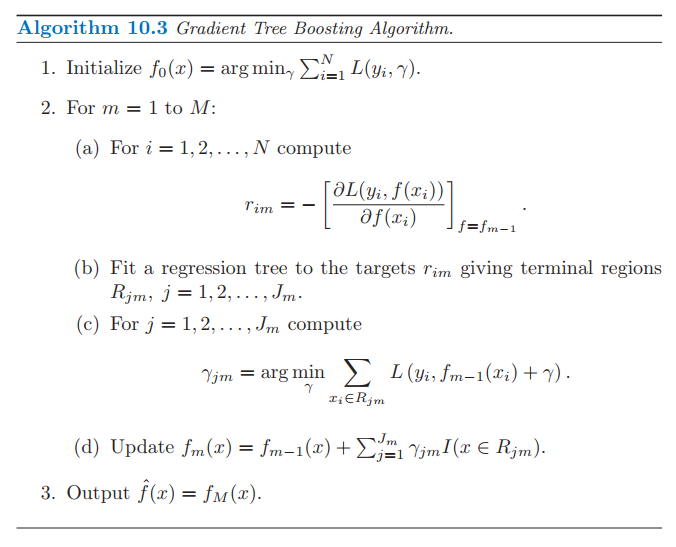

and the usual gradients for commonly used loss functions are as follows.

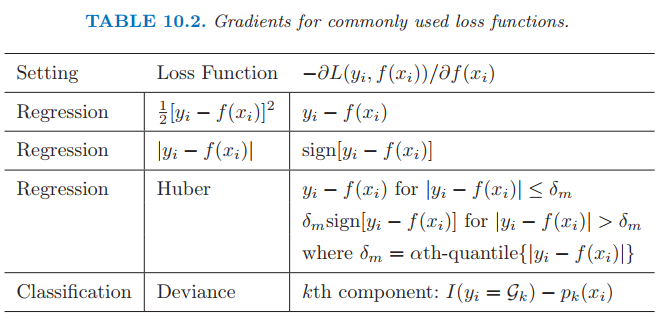

- One can also multiply $\gamma$ by a **shrinkage** ratio $\eta\in[0,1)$ so that the search does not take a full step towards the gradient descent approximation. The rule of thumb mentioned in MLEDU is that with smaller step sizes, you usually need more steps to converge, but lowering step sizes never seem to make overfitting worse. So set the step size to be as small as you have patience for.

- Another variant to gradient tree boosting is that, instead of using the whole training data, **use around half (called bag fraction) of the data stochastically to calculate the gradients**. This is faster and can serve as a regularization and help reduce overfitting. This idea is relating to the mini-batch SGD as well.

- Instead of sampling data, you can sample features in the same token of [bagging](bagging.ipynb). A rule of thumb provided in MLEDU says $20-100\%$. `xgboost` supports this feature.

- The methodology in `xgboost` is almost identical to the above, with two subtle differences: (1) the trees here try to optimize up to second order Taylor approximation of the loss function, rather than just taking first-order derivative into account; (2) `xgboost` regularizes differently than the algo in ESL, but this different regularization allows for simple tree update and intuitive parameter interpretation.

More specifically, the algorithm works as follows.

(a) Using Taylor's expansion to the second order, at each iteration $m=1,\dots, M$.

\begin{align}
\sum_{i=1}^N L(y_i, f^{(m)}) &= \sum_{i=1}^N L(y_i, f^{(m-1)}+\sum_{j=1}^J\gamma_j1(x_i\in R_j))\\
&\approx \sum_{i=1}^N \left[\sum_{j=1}^J(g_i \gamma_j + \frac{1}{2} h_i \gamma_j^2)1(x_i\in R_j)\right] + const.,
\end{align}

where
\begin{align}
g_i = \partial_{f^{(m-1)}} L(y_i, f^{(m-1)}),\;\;h_i = \partial_{f^{(m-1)}}^2 L(y_i, f^{(m-1)})
\end{align}

(b) Using $c J + \frac{1}{2}\lambda \sum_{j=1}^J \gamma_j^2$ as regularization, i.e. penalize the tree size as well as L2 values of $\gamma_j$ (although intuitively it is weird to regulate $\gamma_j$), the final cost function reads 

\begin{align}
\sum_{i=1}^N L(y_i, f^{(m)}) &\approx \sum^J_{j=1} \left[\left(\sum_{x_i\in R_j} g_i\right) \gamma_j + \frac{1}{2} \left(\sum_{x_i\in R_j} h_i + \lambda\right) \gamma_j^2 \right] + c J \\
&= \sum^J_{j=1} \left[G_j\gamma_j + \frac{1}{2} (H_j+\lambda) \gamma_j^2\right] +c J,
\end{align}

where $G_j = \sum_{x_i\in R_j} g_i$ and $H_j = \sum_{x_i\in R_j} h_i$.

In this structure, the gain to split a tree leave into two is rather straightforward:

\begin{align}
Gain = \frac{1}{2} \left[\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{(G_L+G_R)^2}{H_L+H_R+\lambda}\right] - c
\end{align}

And it is clear from the above that $c$ is the hurdle the splitting should overcome to have positive gain; hence the bigger the $c$, the stronger the regularization.

## Theoretical Properties

### Advantages

### Disadvantages

- Boosting cannot be parallelized, since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it does not scale as well as bagging or pasting.
- It typically cannot handle high-cardinality categorical features, since its trees have limited depth.

### Relation to Other Models

## Empirical Performance

### Advantages 

- Empirically, the exponential loss function of AdaBoost is more sensitive to the changes in the estimated class probabilities than just the misclassification rate. Thus compared to just using misclassification as the loss function, empirically it is found that AdaBoost can improve further; see Figure 10.3 in ESL.

### Disadvantages

- Although exponential loss and deviance lead to the same solution on population level as discussed above, they are not the same in practice where one has finite data (note that these two does not contradict each other - an object function and the exponential of the same object function have the same optimum, but drastically different numerical behavior). In particular, **the exponential loss criterion concentrates much more influence on observations with large negative margins and far less robust in noisy settings, especially in situations where there is misspecification of the class labels in the training data**. In such cases, the empirical performance of AdaBoost dramatically degrades.

## Implementation Details and Practical Tricks

**`xgboost`**

There are implementation of AdaBoost and gradient tree boosting in `sklearn`, but it is [said](https://stats.stackexchange.com/questions/282459/xgboost-vs-python-sklearn-gradient-boosted-trees) that `xgboost` is much faster. Hence we will just focus on the usage of `xgboost` here.

- Data Interface: The data is stored in a `DMatrix` object and can load from many formats, including csv and numpy 2D array.
- The training (`train`, `fit`) and predict methods (`predict`, `predict_proba`) are similar to their counterparts in `sklearn`.
- Visualization: use the function `xgboost.plot_importance`; see section below.
- Cross Validation: `xgboost.cv`, accepting the usual parameters such as `nfold`.

In what follows we introduces some selected parameters - **Compare the hyperparameters in xgboost to LightGBM**: [post](https://towardsdatascience.com/beginners-guide-to-the-must-know-lightgbm-hyperparameters-a0005a812702)

- `gamma`: `default=0`, alias: `min_split_loss`
Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger `gamma` is, the more regularized the trees are.

- `max_depth`: `default=6`
Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit.

- `min_child_weight`: `default=1`
Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger `min_child_weight` is, the smaller the trees will be.

- `subsample`: `default=1`
Subsample ratio of the training instances. Setting it to 0.5 means that `XGBoost` would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration. (Not clear if the random sample is with or without replacement).

- `lambda`: `default=1`, alias: `reg_lambda`
L2 regularization term on weights. Increasing this value will make model more conservative.

- `alpha`: `default=0`, alias: `reg_alpha`
L1 regularization term on weights. Increasing this value will make model more conservative.

- `tree_method`: `string`, `default= auto`
The tree construction algorithm used in `XGBoost`. See description in the reference paper in Further Reading.
Distributed and external memory version only support tree_method=approx.
Choices: `auto`, `exact`, `approx`, `hist`, `gpu_exact`, `gpu_hist`
    - auto: Use heuristic to choose the fastest method. 
        - For small to medium dataset, exact greedy (exact) will be used. 
        - For very large dataset, approximate algorithm (approx) will be chosen. 
        - Because old behavior is always use exact greedy in single machine, user will get a message when approximate algorithm is chosen to notify this choice.
    - exact: Exact greedy algorithm.
    - approx: Approximate greedy algorithm using quantile sketch and gradient histogram.
    - hist: Fast histogram optimized approximate greedy algorithm. It uses some performance improvements such as bins caching.
    - gpu_exact: GPU implementation of exact algorithm.
    - gpu_hist: GPU implementation of hist algorithm.

**Right-Sized Trees for Boosting**

The common practice is to restrict the size of all trees by the same positive integar $J$. Thus $J$ becomes a meta-parameter of the entire boosting procedure. As other tree-based method, $J$ determines variable interactions. In practice, low-order interaction effects tend to dominate. When this is the case, models that produce strong higher-order interaction effects, such as large decision trees, suffer in accuracy. It is recommended in ESL to set $4<J<8$, with results being fairly insensitive to particular choices in this range. It is governed by `max_depth` in `xgboost`.

**Regularization**

Again note that `xgboost` and ESL follow different methods in regularization

**Subsampling**

Just as [bagging](bagging.ipynb), at each iteration of boosting we can also just randomly sample a fraction $\eta$ of the training observations. Though it is not clear how `xgboost` does it (controlled by `subsample`), the stochastic gradient boosting introduced in ESL does the sampling without replacement. Typically $\eta$ can be $0.5$, although for large samples $\eta$ can be substantially smaller.

## Use Cases

## Results Interpretation, Metrics and Visualization

Variable importance of boosting trees can be plotted using the `plot_importance` function in `xgboost`. There are three `importance_type` that one can specify in that function:

- `'Weight'`: The number of times a feature is used to split the data across all trees.
- `'Cover'`: The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
- `'Gain'`: The average training loss reduction gained when using a feature for splitting. Note that in ESL, the average is across the squared of the training loss reduction gained; it is called relative importance there.

## References 

- [ESL](https://www.evernote.com/shard/s191/nl/21353936/c2a0e9ac-da49-4fee-8701-3cd70fc42134?title=The%20Elements%20of%20Statistical%20Learning_print12.pdf), Chapter 10
- [`xgboost` Document](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [< Hands-on Machine Learning >](https://www.evernote.com/shard/s191/nl/21353936/e4e0f85e-357a-444d-b1a0-ec9cabd008cb?title=Hands-On%20Machine%20Learning%20with%20Scikit-Learn,%20Keras,%20and%20Tensorflow,%202nd%20Edition), Chapter 7.

### Further Reading

[XGBoost: A Scalable Tree Boosting System](https://arxiv.org/abs/1603.02754)

## Misc.